# Advanced GeoPandas Operations

This notebook covers advanced geospatial operations, performance optimization, and complex geometric transformations.

## Topics Covered:
1. Spatial indexing for performance
2. Complex geometric operations (unions, intersections, differences)
3. Overlay operations and topology
4. Handling large datasets efficiently
5. Custom geometric transformations
6. Performance comparisons and best practices


In [1]:
# Fix for PROJ database path issue
import os
import sys

# Set environment variables to use Homebrew PROJ installation
os.environ['PROJ_DATA'] = '/opt/homebrew/share/proj'
os.environ['PROJ_LIB'] = '/opt/homebrew/share/proj'
os.environ['PROJ_NETWORK'] = 'OFF'

# Now import pyproj
import pyproj
from pyproj import datadir

# Set data directory to Homebrew PROJ
datadir.set_data_dir('/opt/homebrew/share/proj')

print(f"✓ pyproj {pyproj.__version__}")
print(f"✓ PROJ data dir: {datadir.get_data_dir()}")

# Test CRS creation
try:
    from pyproj import CRS
    test_crs = CRS.from_epsg(4326)
    print(f"✓ CRS working: {test_crs.name}")
except Exception as e:
    print(f"✗ CRS failed: {e}")


✓ pyproj 3.7.2
✓ PROJ data dir: /opt/homebrew/share/proj
✓ CRS working: WGS 84


In [2]:
# Import required libraries
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union
import numpy as np
import time

# Set display options
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (14, 8)


## 1. Spatial Indexing for Performance

Spatial indexing dramatically improves performance when working with large datasets. GeoPandas uses R-tree spatial indexing through the `sindex` attribute.


In [3]:
# Create a large dataset of random points
np.random.seed(42)
n_points = 10000

random_points = gpd.GeoDataFrame(
    {'id': range(n_points)},
    geometry=[Point(np.random.uniform(-180, 180), np.random.uniform(-90, 90)) 
              for _ in range(n_points)],
    crs='EPSG:4326'
)

# Create a query polygon
query_poly = Polygon([(-100, 20), (-80, 20), (-80, 40), (-100, 40)])
query_gdf = gpd.GeoDataFrame({'id': [1]}, geometry=[query_poly], crs='EPSG:4326')

print(f"Total points: {len(random_points)}")
print(f"Query polygon bounds: {query_poly.bounds}")


Total points: 10000
Query polygon bounds: (-100.0, 20.0, -80.0, 40.0)


In [5]:
# Method 1: Brute force (no spatial index)
start_time = time.time()
points_in_poly_brute = random_points[random_points.geometry.within(query_poly)]
brute_force_time = time.time() - start_time

# Method 2: Using spatial index
start_time = time.time()
possible_matches_index = list(random_points.sindex.intersection(query_poly.bounds))
possible_matches = random_points.iloc[possible_matches_index]
points_in_poly_indexed = possible_matches[possible_matches.geometry.within(query_poly)]
indexed_time = time.time() - start_time

print(f"\nResults:")
print(f"Points found: {len(points_in_poly_indexed)}")
print(f"\nPerformance Comparison:")
print(f"Brute force time: {brute_force_time:.4f} seconds")
print(f"Spatial index time: {indexed_time:.4f} seconds")
print(f"Speed improvement: {brute_force_time/indexed_time:.1f}x faster")



Results:
Points found: 47

Performance Comparison:
Brute force time: 0.0248 seconds
Spatial index time: 0.0060 seconds
Speed improvement: 4.1x faster


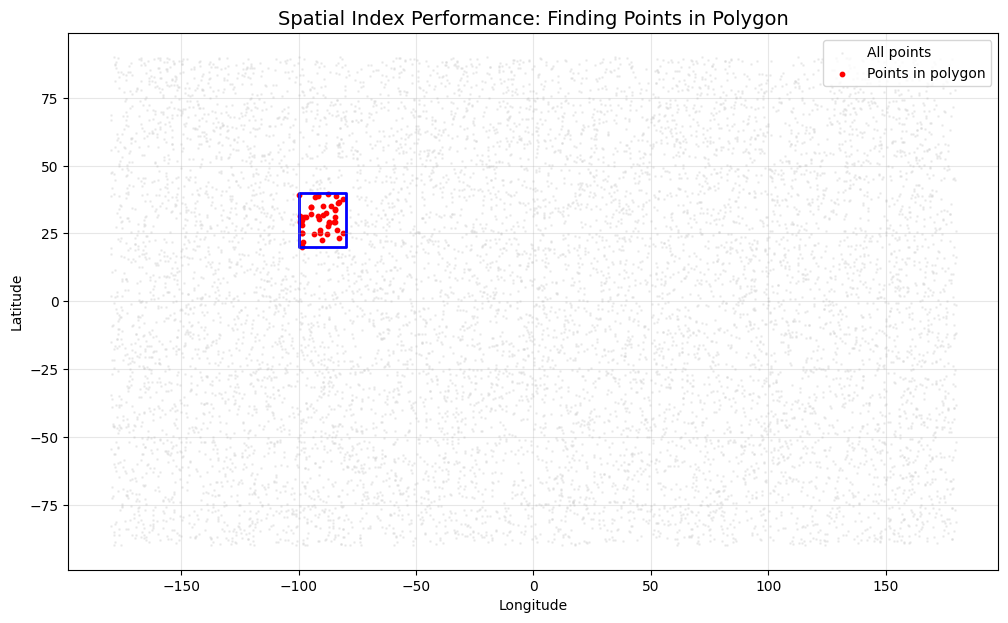

In [6]:
# Visualize the results
fig, ax = plt.subplots(figsize=(12, 8))

# Plot all points in gray
random_points.plot(ax=ax, color='lightgray', markersize=1, alpha=0.3, label='All points')

# Highlight points within polygon
points_in_poly_indexed.plot(ax=ax, color='red', markersize=10, label='Points in polygon')

# Plot query polygon
query_gdf.plot(ax=ax, facecolor='none', edgecolor='blue', linewidth=2, label='Query polygon')

plt.title('Spatial Index Performance: Finding Points in Polygon', fontsize=14)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


## 2. Complex Geometric Operations

### 2.1 Union Operations


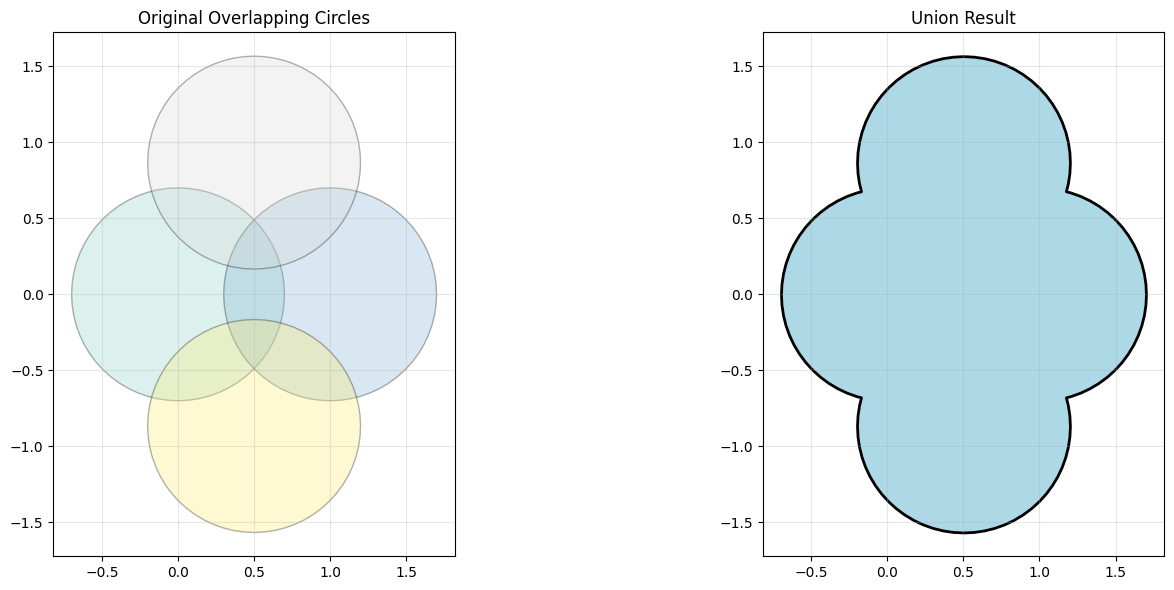

Original geometries: 4
Union result type: Polygon
Union area: 4.9395


In [7]:
# Create several overlapping circles
circles = []
centers = [(0, 0), (1, 0), (0.5, 0.866), (0.5, -0.866)]

for i, (x, y) in enumerate(centers):
    circle = Point(x, y).buffer(0.7)
    circles.append({'id': i, 'geometry': circle})

circles_gdf = gpd.GeoDataFrame(circles)

# Union all circles into a single geometry
union_result = unary_union(circles_gdf.geometry)

# Visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Original circles
circles_gdf.plot(ax=ax1, alpha=0.3, edgecolor='black', cmap='Set3')
ax1.set_title('Original Overlapping Circles', fontsize=12)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Union result
gpd.GeoSeries([union_result]).plot(ax=ax2, color='lightblue', edgecolor='black', linewidth=2)
ax2.set_title('Union Result', fontsize=12)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Original geometries: {len(circles_gdf)}")
print(f"Union result type: {union_result.geom_type}")
print(f"Union area: {union_result.area:.4f}")


### 2.2 Intersection and Difference


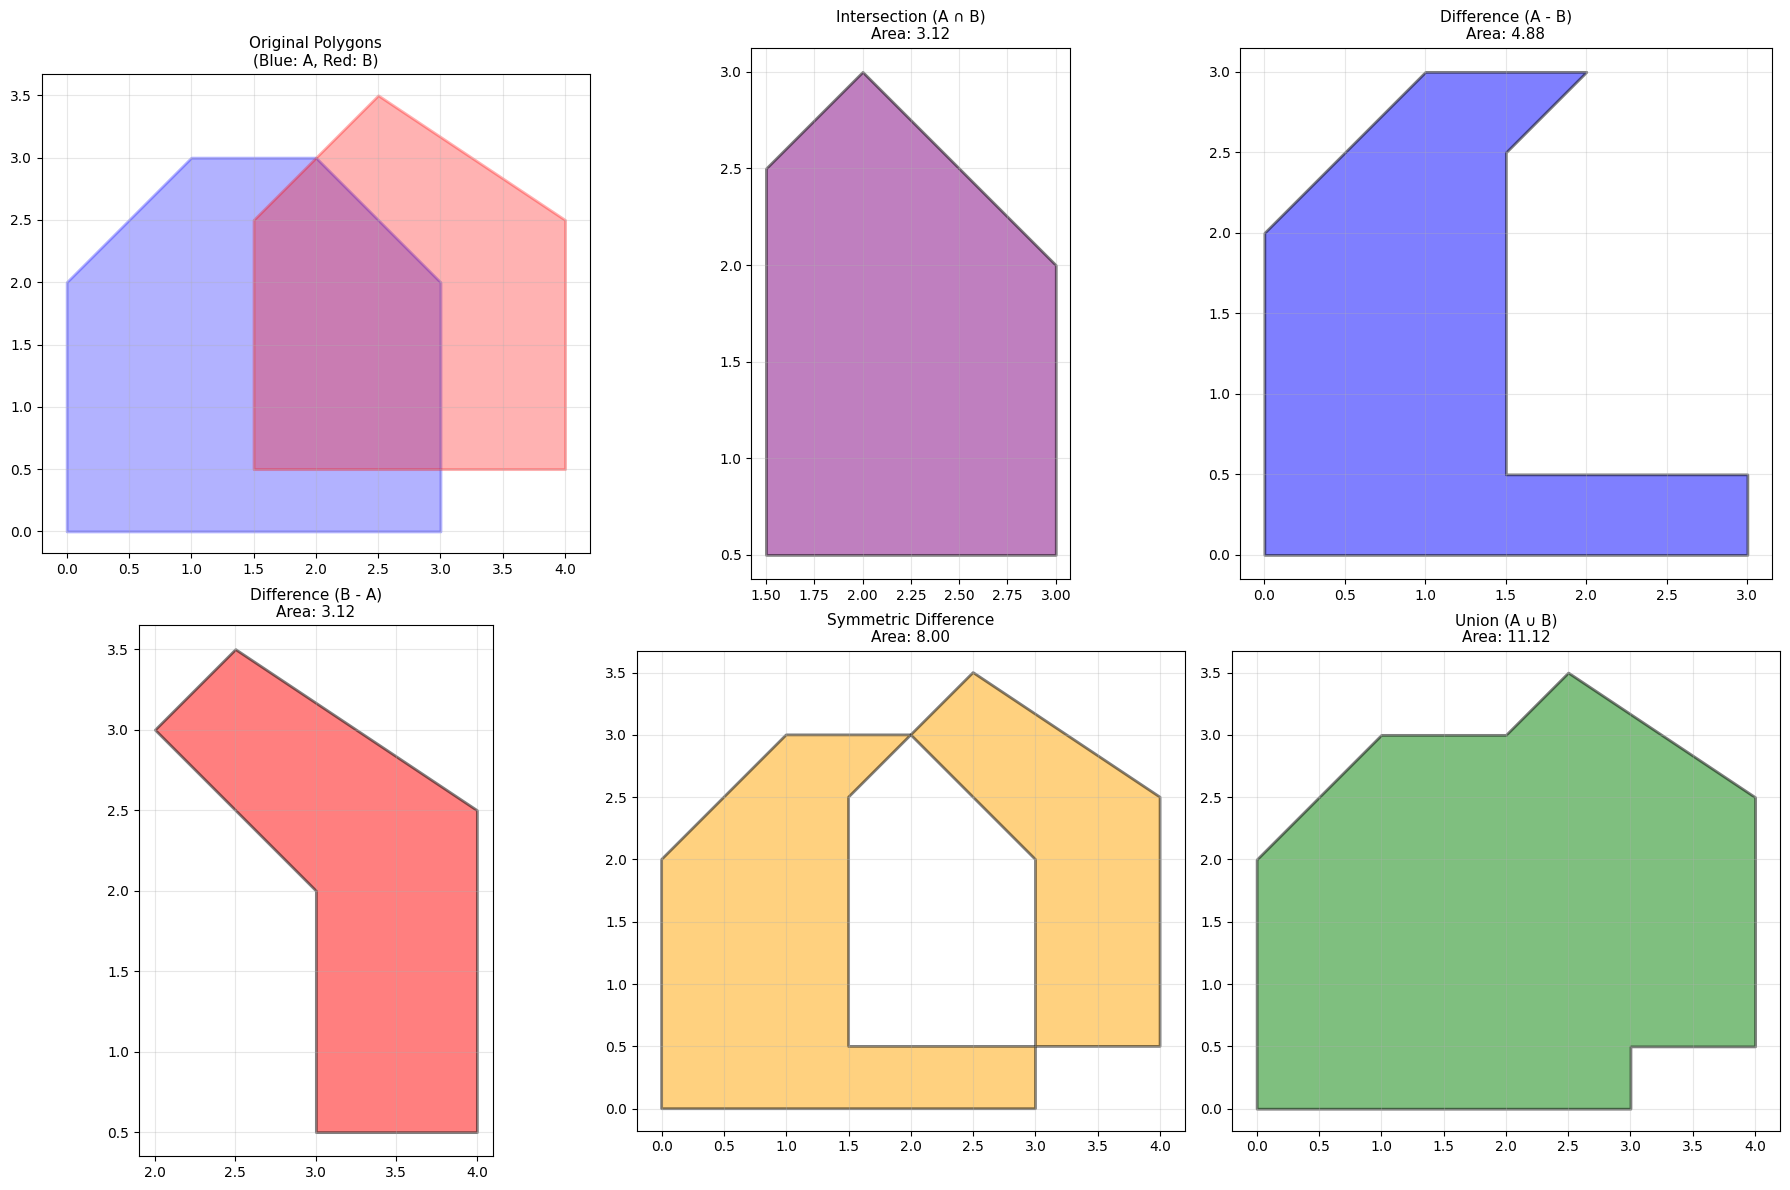

In [8]:
# Create two complex polygons
poly_a = Polygon([(0, 0), (3, 0), (3, 2), (2, 3), (1, 3), (0, 2)])
poly_b = Polygon([(1.5, 0.5), (4, 0.5), (4, 2.5), (2.5, 3.5), (1.5, 2.5)])

# Calculate various operations
intersection = poly_a.intersection(poly_b)
difference_a_b = poly_a.difference(poly_b)  # A - B
difference_b_a = poly_b.difference(poly_a)  # B - A
symmetric_diff = poly_a.symmetric_difference(poly_b)  # (A - B) + (B - A)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Original polygons
ax = axes[0]
gpd.GeoSeries([poly_a]).plot(ax=ax, color='blue', alpha=0.3, edgecolor='blue', linewidth=2)
gpd.GeoSeries([poly_b]).plot(ax=ax, color='red', alpha=0.3, edgecolor='red', linewidth=2)
ax.set_title('Original Polygons\n(Blue: A, Red: B)', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Intersection
ax = axes[1]
gpd.GeoSeries([intersection]).plot(ax=ax, color='purple', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title(f'Intersection (A ∩ B)\nArea: {intersection.area:.2f}', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Difference A - B
ax = axes[2]
gpd.GeoSeries([difference_a_b]).plot(ax=ax, color='blue', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title(f'Difference (A - B)\nArea: {difference_a_b.area:.2f}', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Difference B - A
ax = axes[3]
gpd.GeoSeries([difference_b_a]).plot(ax=ax, color='red', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title(f'Difference (B - A)\nArea: {difference_b_a.area:.2f}', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Symmetric difference
ax = axes[4]
gpd.GeoSeries([symmetric_diff]).plot(ax=ax, color='orange', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title(f'Symmetric Difference\nArea: {symmetric_diff.area:.2f}', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

# Union
union = poly_a.union(poly_b)
ax = axes[5]
gpd.GeoSeries([union]).plot(ax=ax, color='green', alpha=0.5, edgecolor='black', linewidth=2)
ax.set_title(f'Union (A ∪ B)\nArea: {union.area:.2f}', fontsize=11)
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [9]:
# Create two sets of polygons representing different zones
zones_a = gpd.GeoDataFrame({
    'zone_type': ['Residential', 'Commercial'],
    'geometry': [
        Polygon([(0, 0), (4, 0), (4, 3), (0, 3)]),
        Polygon([(2, 1), (6, 1), (6, 4), (2, 4)])
    ]
})

zones_b = gpd.GeoDataFrame({
    'protection_level': ['High', 'Medium'],
    'geometry': [
        Polygon([(1, -1), (3, -1), (3, 2), (1, 2)]),
        Polygon([(3.5, 1.5), (5.5, 1.5), (5.5, 3.5), (3.5, 3.5)])
    ]
})

# Perform overlay operations
overlay_intersection = gpd.overlay(zones_a, zones_b, how='intersection')
overlay_union = gpd.overlay(zones_a, zones_b, how='union')
overlay_difference = gpd.overlay(zones_a, zones_b, how='difference')

print("Overlay Intersection:")
print(overlay_intersection)
print(f"\nNumber of resulting polygons: {len(overlay_intersection)}")


Overlay Intersection:
     zone_type protection_level  \
0  Residential             High   
1  Residential           Medium   
2   Commercial             High   
3   Commercial           Medium   

                                            geometry  
0                POLYGON ((1 0, 1 2, 3 2, 3 0, 1 0))  
1        POLYGON ((4 3, 4 1.5, 3.5 1.5, 3.5 3, 4 3))  
2                POLYGON ((2 1, 2 2, 3 2, 3 1, 2 1))  
3  POLYGON ((3.5 3.5, 5.5 3.5, 5.5 1.5, 3.5 1.5, ...  

Number of resulting polygons: 4


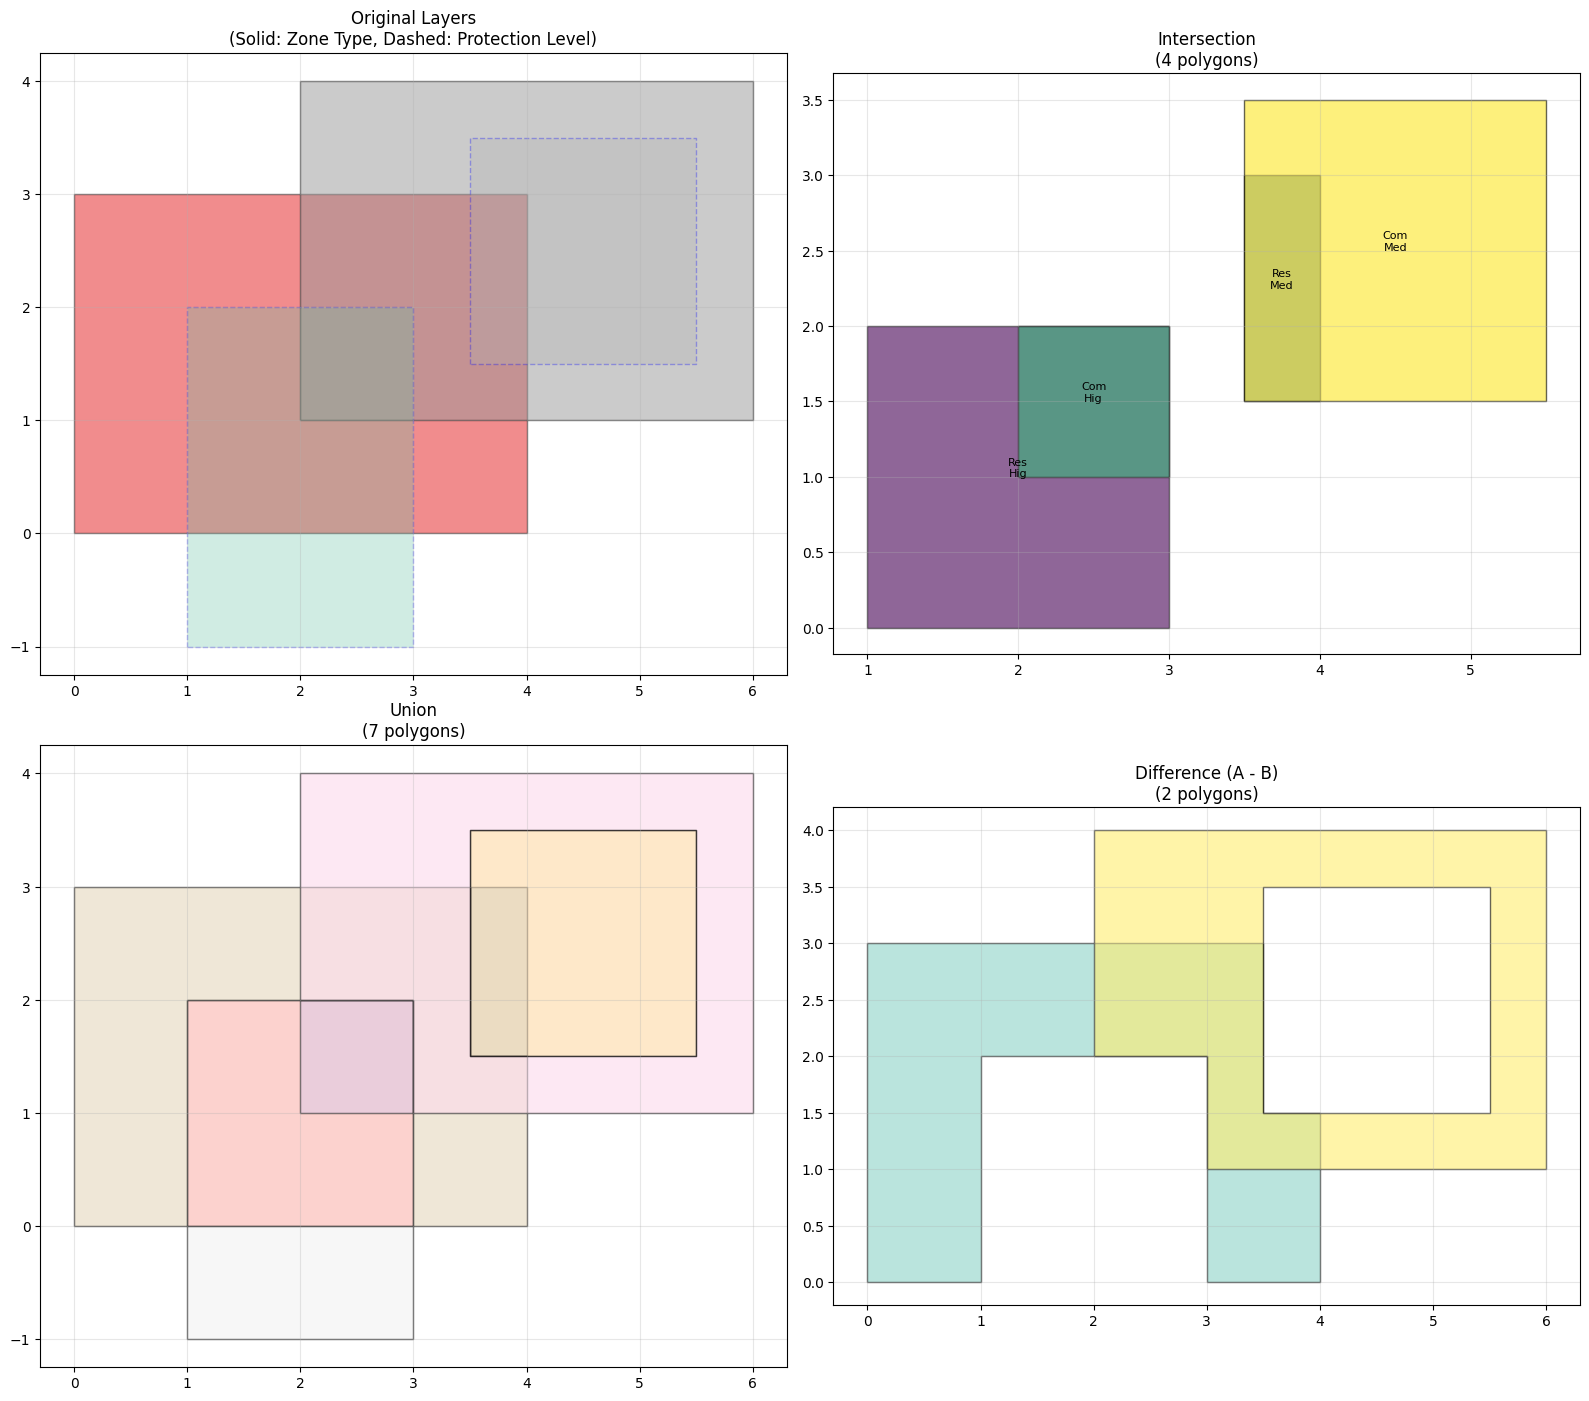

In [10]:
# Visualize overlay operations
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Original layers
ax = axes[0, 0]
zones_a.plot(ax=ax, alpha=0.5, edgecolor='black', cmap='Set1', legend=True)
zones_b.plot(ax=ax, alpha=0.3, edgecolor='blue', cmap='Set2', linestyle='--', legend=True)
ax.set_title('Original Layers\n(Solid: Zone Type, Dashed: Protection Level)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Intersection
ax = axes[0, 1]
overlay_intersection.plot(ax=ax, alpha=0.6, edgecolor='black', cmap='viridis')
for idx, row in overlay_intersection.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(f"{row['zone_type'][:3]}\n{row['protection_level'][:3]}", 
                xy=(centroid.x, centroid.y), ha='center', fontsize=8)
ax.set_title(f'Intersection\n({len(overlay_intersection)} polygons)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Union
ax = axes[1, 0]
overlay_union.plot(ax=ax, alpha=0.6, edgecolor='black', cmap='Pastel1')
ax.set_title(f'Union\n({len(overlay_union)} polygons)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

# Difference (A - B)
ax = axes[1, 1]
overlay_difference.plot(ax=ax, alpha=0.6, edgecolor='black', cmap='Set3')
ax.set_title(f'Difference (A - B)\n({len(overlay_difference)} polygons)', fontsize=12)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


## 4. Handling Large Datasets Efficiently

### 4.1 Dissolve and Aggregation


In [11]:
# Load world data directly from Natural Earth  
world = gpd.read_file('https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip')

print(f"Original world data: {len(world)} countries")

# Dissolve by continent (merge all countries in each continent)
continents = world.dissolve(by='CONTINENT', aggfunc='sum')

print(f"After dissolving by continent: {len(continents)} continents")
print(f"\nContinents with total population:")
print(continents[['POP_EST']].sort_values('POP_EST', ascending=False))


Original world data: 177 countries
After dissolving by continent: 8 continents

Continents with total population:
                              POP_EST
CONTINENT                            
Asia                     4.550277e+09
Africa                   1.306370e+09
Europe                   7.454125e+08
North America            5.837560e+08
South America            4.270667e+08
Oceania                  4.120487e+07
Antarctica               4.490000e+03
Seven seas (open ocean)  1.400000e+02


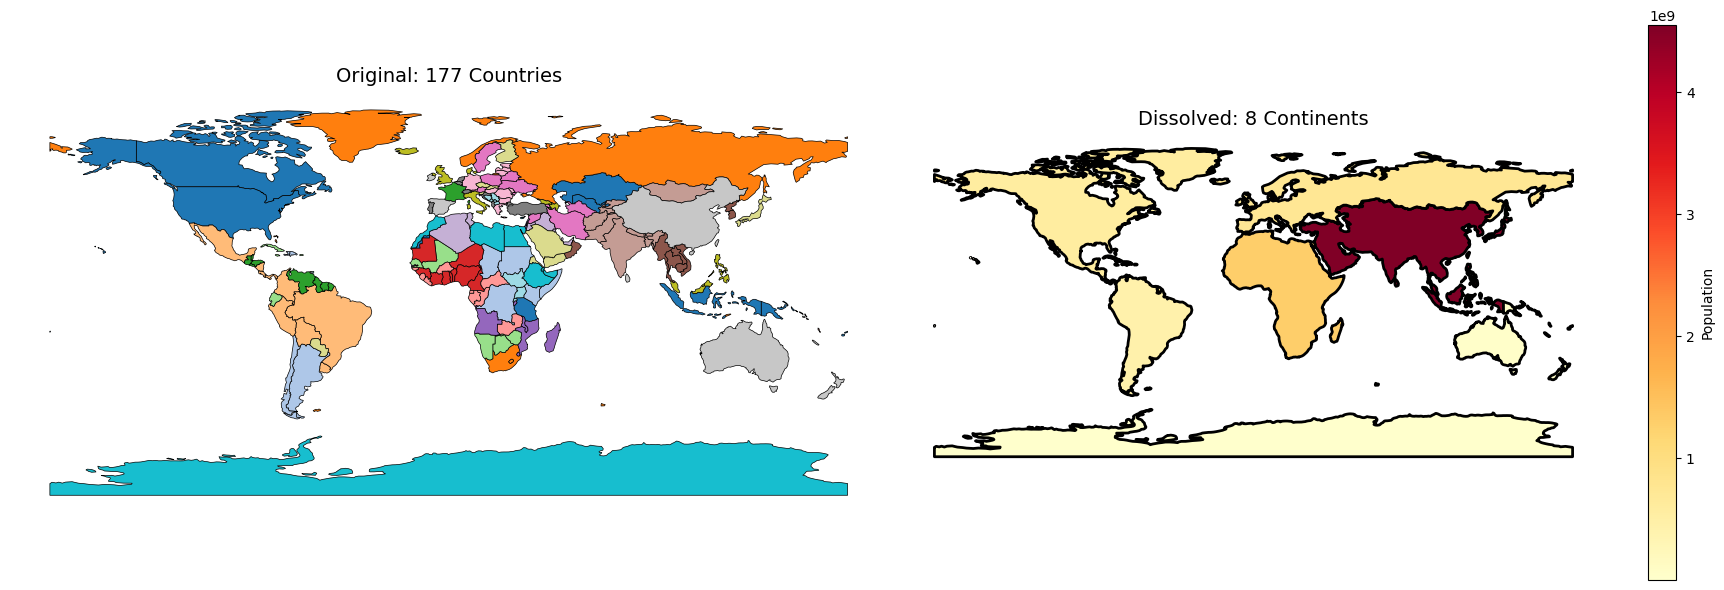

In [12]:
# Visualize before and after dissolve
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

world.plot(ax=ax1, edgecolor='black', linewidth=0.5, cmap='tab20')
ax1.set_title(f'Original: {len(world)} Countries', fontsize=14)
ax1.axis('off')

continents.plot(ax=ax2, column='POP_EST', legend=True, cmap='YlOrRd', 
                edgecolor='black', linewidth=2, legend_kwds={'label': 'Population'})
ax2.set_title(f'Dissolved: {len(continents)} Continents', fontsize=14)
ax2.axis('off')

plt.tight_layout()
plt.show()


### 4.2 Simplify Geometries for Performance


Tolerance 0: 2230 vertices
Tolerance 0.1: 1642 vertices
Tolerance 0.5: 600 vertices
Tolerance 1.0: 384 vertices


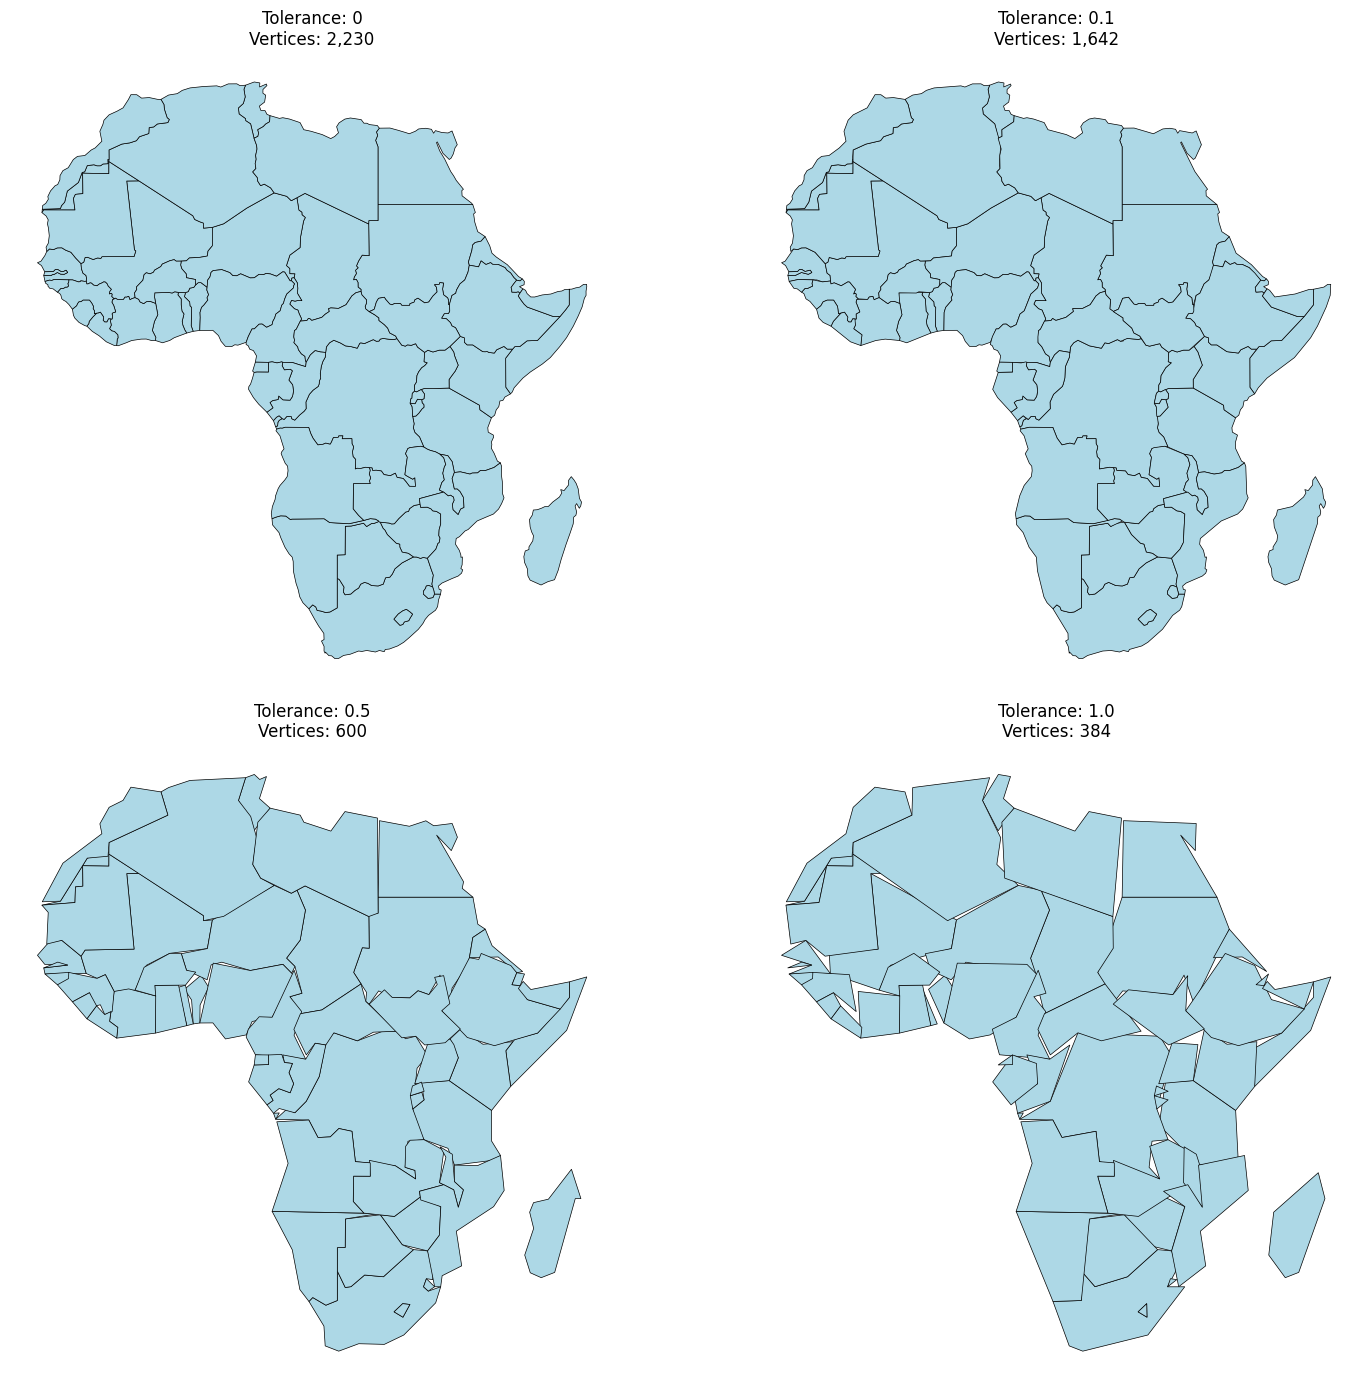

In [13]:
# Simplify complex geometries (useful for large datasets)
africa = world[world['CONTINENT'] == 'Africa'].copy()

# Apply different levels of simplification
tolerance_values = [0, 0.1, 0.5, 1.0]
simplified_versions = []

for tol in tolerance_values:
    if tol == 0:
        simplified = africa.copy()
    else:
        simplified = africa.copy()
        simplified['geometry'] = africa.geometry.simplify(tolerance=tol)
    
    # Count total vertices
    total_vertices = sum(len(list(geom.exterior.coords)) if geom.geom_type == 'Polygon' 
                        else sum(len(list(p.exterior.coords)) for p in geom.geoms)
                        for geom in simplified.geometry)
    
    simplified_versions.append((tol, simplified, total_vertices))
    print(f"Tolerance {tol}: {total_vertices} vertices")

# Visualize different simplification levels
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

for idx, (tol, gdf, vertices) in enumerate(simplified_versions):
    ax = axes[idx]
    gdf.plot(ax=ax, edgecolor='black', facecolor='lightblue', linewidth=0.5)
    ax.set_title(f'Tolerance: {tol}\nVertices: {vertices:,}', fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()


## 5. Custom Geometric Transformations

### 5.1 Affine Transformations


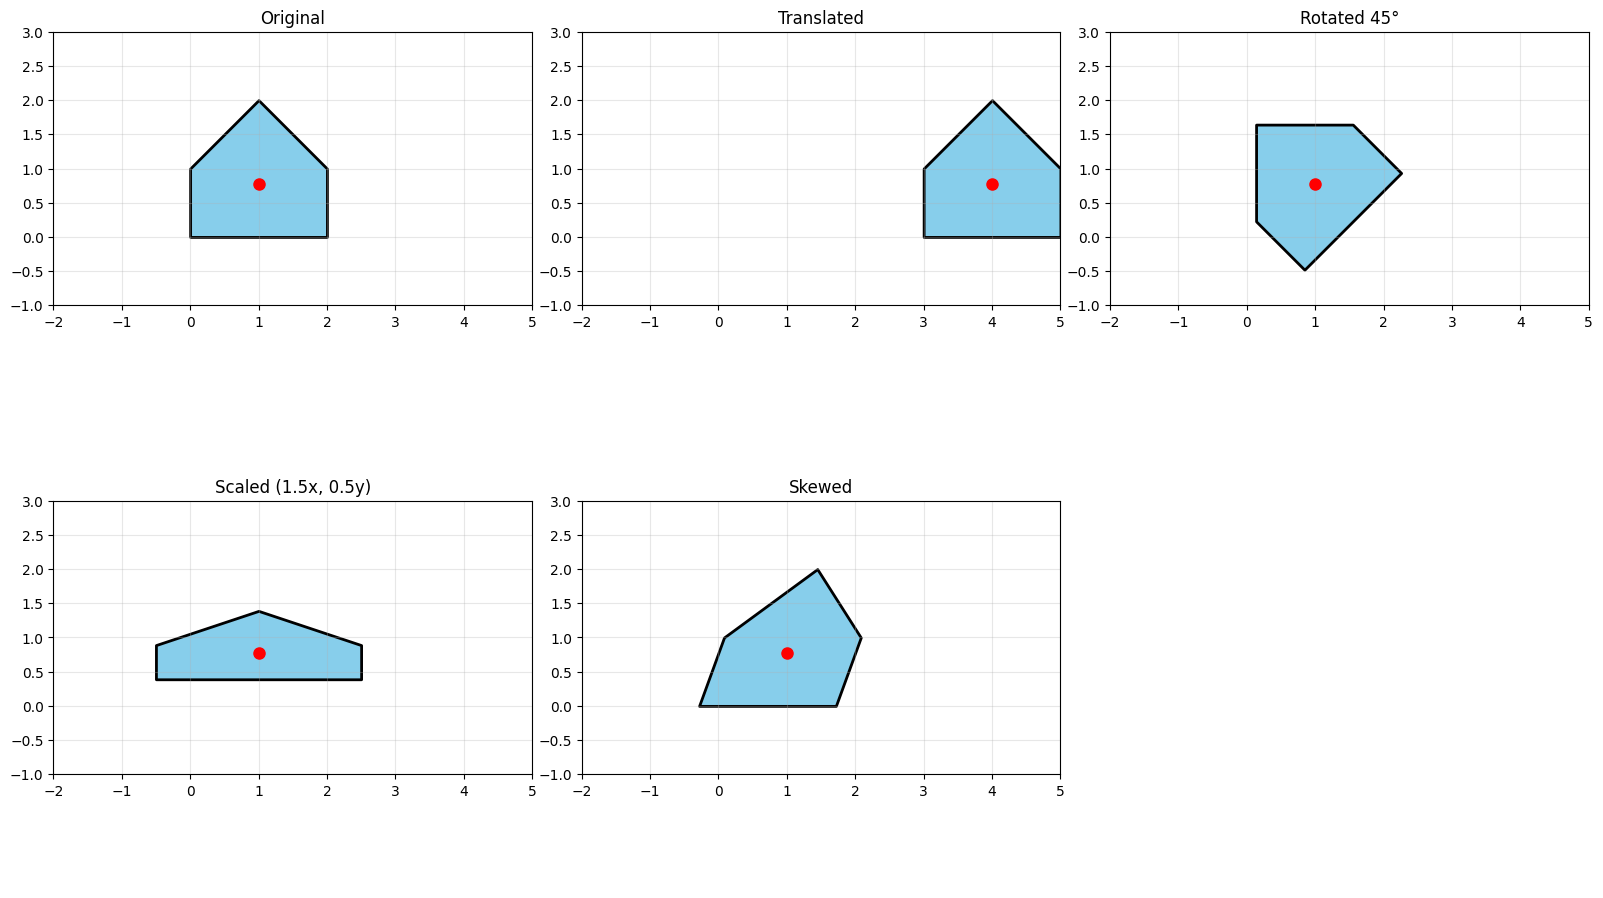

In [14]:
# Create a simple polygon
from shapely import affinity

original = Polygon([(0, 0), (2, 0), (2, 1), (1, 2), (0, 1)])

# Apply various transformations
translated = affinity.translate(original, xoff=3, yoff=0)
rotated = affinity.rotate(original, 45, origin='centroid')
scaled = affinity.scale(original, xfact=1.5, yfact=0.5, origin='centroid')
skewed = affinity.skew(original, xs=20, ys=0, origin='centroid')

# Create GeoDataFrame
transformations = gpd.GeoDataFrame({
    'type': ['Original', 'Translated', 'Rotated 45°', 'Scaled (1.5x, 0.5y)', 'Skewed'],
    'geometry': [original, translated, rotated, scaled, skewed]
})

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, (_, row) in enumerate(transformations.iterrows()):
    ax = axes[idx]
    gpd.GeoSeries([row.geometry]).plot(ax=ax, color='skyblue', edgecolor='black', linewidth=2)
    
    # Show centroid
    centroid = row.geometry.centroid
    ax.plot(centroid.x, centroid.y, 'ro', markersize=8)
    
    ax.set_title(row['type'], fontsize=12)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2, 5)
    ax.set_ylim(-1, 3)

# Remove extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


### 5.2 Convex Hull and Envelope


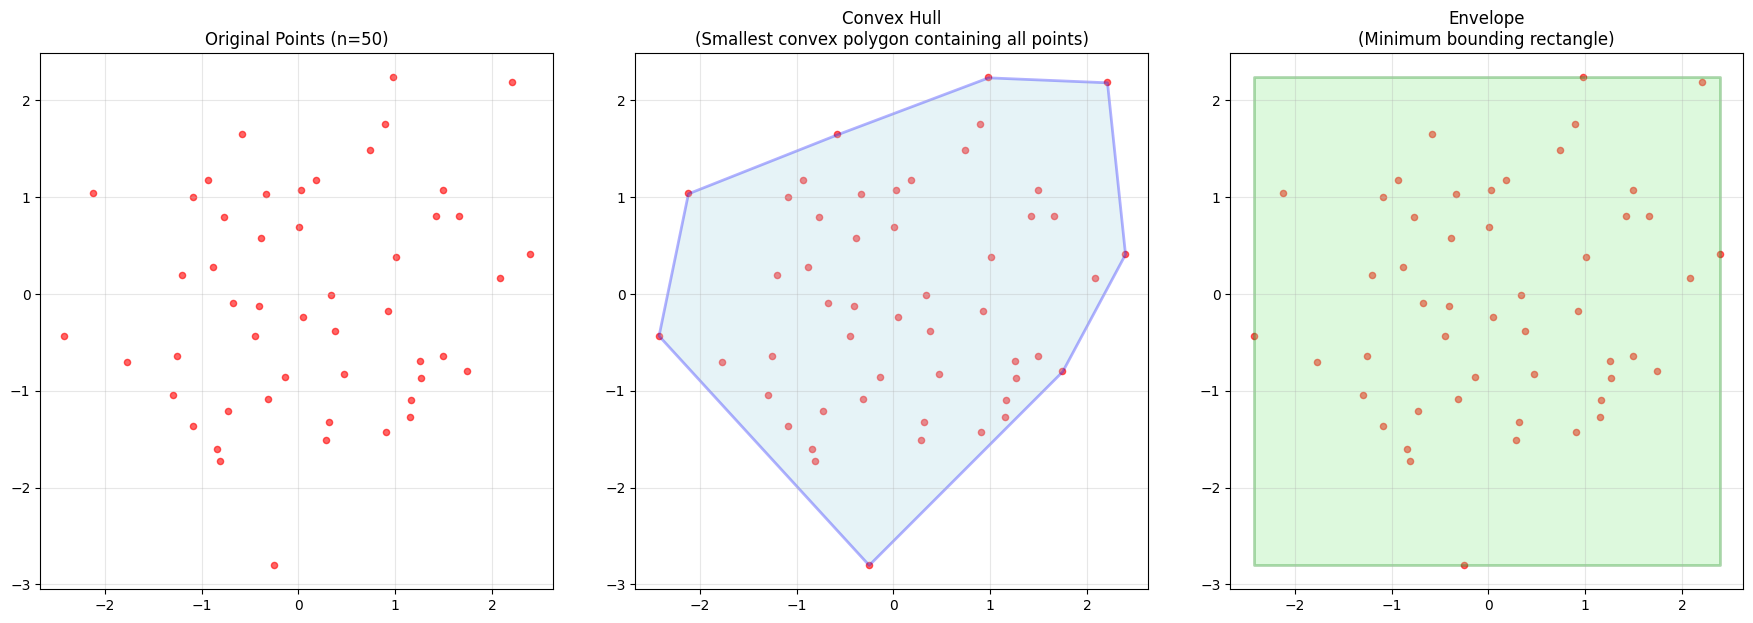

Convex hull area: 15.3810
Envelope area: 24.2722


In [15]:
# Create random point cloud
np.random.seed(123)
n = 50
points = [Point(np.random.randn(), np.random.randn()) for _ in range(n)]
points_gdf = gpd.GeoDataFrame(geometry=points)

# Create MultiPoint and compute convex hull and envelope
from shapely.geometry import MultiPoint
multipoint = MultiPoint(points)
convex_hull = multipoint.convex_hull
envelope = multipoint.envelope

# Visualize
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Original points
points_gdf.plot(ax=ax1, color='red', markersize=20, alpha=0.6)
ax1.set_title(f'Original Points (n={n})', fontsize=12)
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)

# Convex hull
points_gdf.plot(ax=ax2, color='red', markersize=20, alpha=0.6)
gpd.GeoSeries([convex_hull]).plot(ax=ax2, facecolor='lightblue', edgecolor='blue', 
                                   alpha=0.3, linewidth=2)
ax2.set_title('Convex Hull\n(Smallest convex polygon containing all points)', fontsize=12)
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)

# Envelope (bounding box)
points_gdf.plot(ax=ax3, color='red', markersize=20, alpha=0.6)
gpd.GeoSeries([envelope]).plot(ax=ax3, facecolor='lightgreen', edgecolor='green', 
                                alpha=0.3, linewidth=2)
ax3.set_title('Envelope\n(Minimum bounding rectangle)', fontsize=12)
ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Convex hull area: {convex_hull.area:.4f}")
print(f"Envelope area: {envelope.area:.4f}")


## 6. Performance Best Practices

### 6.1 Batch Operations vs Iterative


Performance Comparison for Area Calculation:
Iterative (for loop): 0.0154 seconds
Apply function: 0.0017 seconds
Vectorized operation: 0.0001 seconds

Speedup (vectorized vs iterative): 102.5x faster


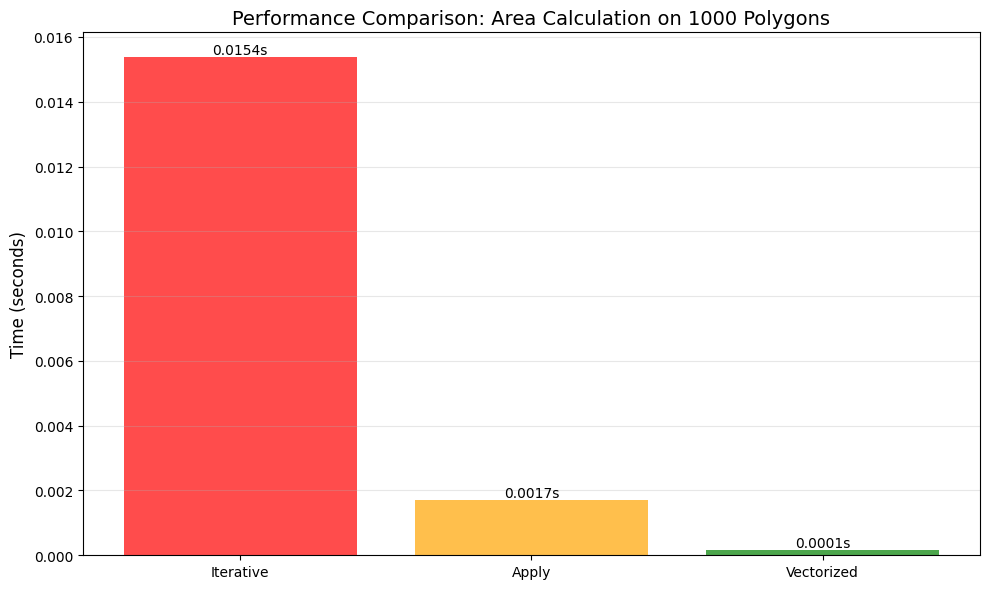

In [16]:
# Create test dataset
np.random.seed(42)
n_geoms = 1000
test_polys = gpd.GeoDataFrame({
    'id': range(n_geoms),
    'geometry': [Point(np.random.uniform(-10, 10), np.random.uniform(-10, 10)).buffer(0.5) 
                 for _ in range(n_geoms)]
})

# Method 1: Iterative (slow)
start = time.time()
areas_iterative = []
for idx, row in test_polys.iterrows():
    areas_iterative.append(row.geometry.area)
time_iterative = time.time() - start

# Method 2: Vectorized (fast)
start = time.time()
areas_vectorized = test_polys.geometry.area
time_vectorized = time.time() - start

# Method 3: Apply with lambda (medium)
start = time.time()
areas_apply = test_polys.geometry.apply(lambda x: x.area)
time_apply = time.time() - start

print("Performance Comparison for Area Calculation:")
print(f"Iterative (for loop): {time_iterative:.4f} seconds")
print(f"Apply function: {time_apply:.4f} seconds")
print(f"Vectorized operation: {time_vectorized:.4f} seconds")
print(f"\nSpeedup (vectorized vs iterative): {time_iterative/time_vectorized:.1f}x faster")

# Visualize timing
methods = ['Iterative', 'Apply', 'Vectorized']
times = [time_iterative, time_apply, time_vectorized]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(methods, times, color=['red', 'orange', 'green'], alpha=0.7)
ax.set_ylabel('Time (seconds)', fontsize=12)
ax.set_title(f'Performance Comparison: Area Calculation on {n_geoms} Polygons', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{time_val:.4f}s', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


## Summary

In this notebook, we explored advanced GeoPandas operations:

**Performance Optimization:**
- Spatial indexing with R-tree for faster queries
- Vectorized operations vs iterative approaches
- Geometry simplification to reduce complexity

**Complex Operations:**
- Union, intersection, difference, and symmetric difference
- Overlay operations combining multiple layers
- Dissolve and aggregation for data consolidation

**Geometric Transformations:**
- Affine transformations (translate, rotate, scale, skew)
- Convex hull and envelope calculations
- Custom geometric manipulations

**Best Practices:**
- Always use spatial indexing for large datasets
- Prefer vectorized operations over loops
- Simplify geometries when appropriate
- Choose the right CRS for your analysis

These advanced techniques enable efficient processing of large-scale geospatial data!
